### Clustering: k-means and linkage-based clustering

In this notebook we are going to practice with the k-means and the linkage-based (called "agglomerative" in sklearn) clustering algorithms.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In [1]:
#load the required packages
%matplotlib inline  
import math 
import numpy as np
import scipy as sp
import imageio as imio
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from mpl_toolkits.mplot3d import Axes3D #3d plotting functions
from matplotlib import pyplot
from PIL import Image

from copy import deepcopy  #deepcopy ensures that a copy of all the object data is performed (not just the pointers)

## TO DO:
    
Place your ID number in the ID variable, it will be used as random seed (as usual the random seed can affect a little bit the results)

In [2]:
# fix your ID ("numero di matricola") and the seed for random generator
ID = 1206077  #insert your ID number here
np.random.seed(ID)

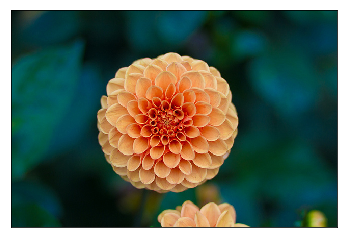

Flower image:  (427, 640, 3)


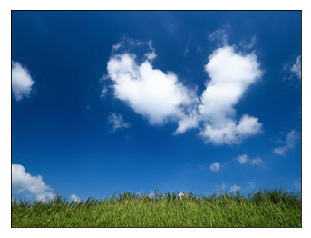

Landscape image:  (240, 320, 3)


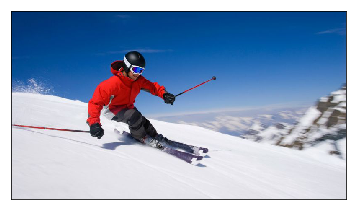

Skiing image:  (451, 800, 3)


In [3]:
# load the images and display them
flower = load_sample_image('flower.jpg')
landscape = imio.imread("data/landscape.jpg")
skiing = imio.imread("data/skiing.jpg")

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower)
plt.show()
print("Flower image: ",flower.shape)

ax2 = plt.axes(xticks=[], yticks=[])
ax2.imshow(landscape)
plt.show()
print("Landscape image: ",landscape.shape)

ax3 = plt.axes(xticks=[], yticks=[])
ax3.imshow(skiing)
plt.show()
print("Skiing image: ",skiing.shape)

We are going to start by using the flower image. It will be rescaled of a factor 8 to speed up the computation.


[[[0.02064373 0.08338883 0.05812061]
  [0.05490196 0.11372549 0.09411765]
  [0.12341842 0.17047725 0.14890862]
  ...
  [0.00392157 0.3163892  0.29100999]
  [0.         0.30680725 0.28616352]
  [0.00196078 0.29100999 0.25893452]]

 [[0.03414724 0.09885313 0.08120607]
  [0.07647059 0.13529412 0.11568627]
  [0.145431   0.19248983 0.15327414]
  ...
  [0.         0.2745098  0.24476508]
  [0.00392157 0.27891232 0.25260821]
  [0.00310766 0.26355901 0.2372549 ]]

 [[0.03866075 0.11106178 0.10140585]
  [0.07536071 0.14846467 0.13388827]
  [0.12689604 0.18893822 0.18220496]
  ...
  [0.00196078 0.23599704 0.23318535]
  [0.00266371 0.24580096 0.24187939]
  [0.00196078 0.24258232 0.23710692]]

 ...

 [[0.         0.17843137 0.12745098]
  [0.00125786 0.18557159 0.11498335]
  [0.         0.18823529 0.1254902 ]
  ...
  [0.01920089 0.22186459 0.11176471]
  [0.0072882  0.19944506 0.11568627]
  [0.02212357 0.18964114 0.13584906]]

 [[0.00392157 0.18823529 0.154569  ]
  [0.00196078 0.18594155 0.12663707]


/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


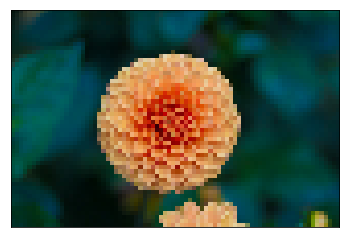

In [4]:
# Rescale the image of a factor of 8
# The anti-aliasing can be enabled for better performances but requires a recent version of the python packages

#flower_rescaled = rescale(flower, 1.0 / 8.0, anti_aliasing=True, multichannel=True) #new versions
flower_rescaled = rescale(flower, 1.0 / 8.0)  # better compatibility


print(flower_rescaled)
# Firstly, we are going to visualize the rescaled version
print(flower_rescaled.shape)
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower_rescaled);

In [5]:
# reshape the data to a matrix of num_pixels x 3

data_rescaled = flower_rescaled.reshape(flower_rescaled.shape[0]*flower_rescaled.shape[1], 3)

print(data_rescaled.shape)
print(data_rescaled)

(4240, 3)
[[0.02064373 0.08338883 0.05812061]
 [0.05490196 0.11372549 0.09411765]
 [0.12341842 0.17047725 0.14890862]
 ...
 [0.16056234 0.27243803 0.05882353]
 [0.02560118 0.17946726 0.0745098 ]
 [0.01590825 0.17162412 0.09411765]]


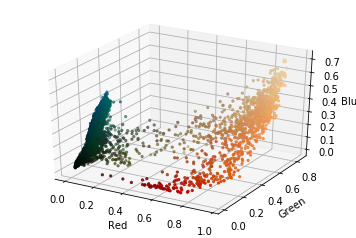

In [6]:
# Plot the points in the 3-dimensional space with normalized intervals between 0 and 1
# (corresponding to the three channels of the image, i.e. Red Green and Blue)



fig = pyplot.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
r, g, b = list(data_rescaled[:,0]), list(data_rescaled[:,1]), list(data_rescaled[:,2])

axis.scatter(r, g, b, c=data_rescaled, s=5, marker="o")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()

## TO DO 1
Implement the k-means algorithm manually (do not use the kmeans function of sklearn). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

In [7]:
def my_kmeans(points, k):
    max_iters=50

    index_k=np.random.randint(0,len(points),k)

    '''all interno di point alla fine si avranno per ciascuna riga:
            -le prime 3 colonne saranno le coordinate del punto
            -la quarta sarà il label associato
            -le altre saranno gli errori associati a ogni iterazione'''

    label=np.zeros((len(points),1))
    for i in range(len(points)):
        dist=[]
        for j in index_k:
            dist.append(((((points[i][0]-points[j][0])**2)+((points[i][1]-points[j][1])**2)+((points[i][2]-points[j][2])**2))**0.5))
        label[i]=np.argmin(dist)

    points=np.hstack((points,label))
    #print(points)
    


    centri=np.zeros((k,3))
    errori=np.zeros((max_iters))
    for ite in range(max_iters):

        for j in range(k):                         
            new_cent=np.zeros((3))
            conteggi=0
            for i in range(len(points)):
                if points[i][3]==j:
                    new_cent[0]+=points[i][0]
                    new_cent[1]+=points[i][1]
                    new_cent[2]+=points[i][2]
                    conteggi+=1
            centri[j][0]=new_cent[0]/conteggi
            centri[j][1]=new_cent[1]/conteggi
            centri[j][2]=new_cent[2]/conteggi
            #print(centri)


        '''aggiorno il label'''
        label=np.zeros((len(points),1))
        for i in range(len(points)):
            dist=[]
            for j in range(k):
                dist.append(((((points[i][0]-centri[j][0])**2)+((points[i][1]-centri[j][1])**2)+((points[i][2]-centri[j][2])**2))**0.5))
            label[i]=np.argmin(dist)
            points[i][3]=label[i]

        '''creo gli errori'''
        distanza=0
        for i in range(len(points)):
            for j in range(k):
                if points[i][3]==j:
                    distanza+=(((points[i][0]-centri[j][0])**2)+((points[i][1]-centri[j][1])**2)+((points[i][2]-centri[j][2])**2))
                    errori[ite]=distanza
    
    
    centroids=centri
    clusters=points
    error=errori
    return centroids, clusters, error
    
               

        
        

## TO DO 2:

Now try the function you developed on the flower image with two clusters (k=2). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one or the other cluster. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

In [8]:
mykmeans_centers,clusters,error =my_kmeans(data_rescaled,2)

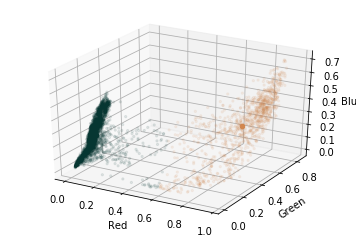

In [9]:

cluster0=clusters[clusters[:,3]==0]
cluster1=clusters[clusters[:,3]==1]

fig = pyplot.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

r_0, g_0, b_0 = cluster0[:,0], cluster0[:,1], cluster0[:,2]
r_1, g_1, b_1 = cluster1[:,0], cluster1[:,1], cluster1[:,2]
color_0=mykmeans_centers[0,0:3]
color_1=mykmeans_centers[1,0:3]


axis.scatter(r_0, g_0, b_0, c=color_0, s=5, marker="o", alpha=0.09)
axis.scatter(r_1, g_1, b_1, c=color_1, s=5, marker="o", alpha=0.09)
axis.scatter(mykmeans_centers[0,0],mykmeans_centers[0,1],mykmeans_centers[0,2],color=color_0,alpha=1)
axis.scatter(mykmeans_centers[1,0],mykmeans_centers[1,1],mykmeans_centers[1,2],color=color_1,alpha=1)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()



## TO DO 3: 
Plot the value of the error versus the number of iterations

Text(0,0.5,'error')

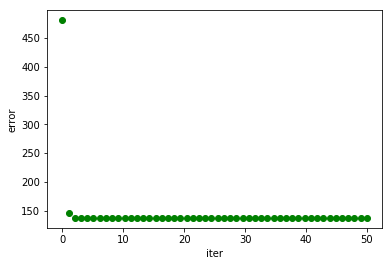

In [10]:
iteration=np.linspace(0,50,50)
plt.plot(iteration,error,'o',color='green')
plt.xlabel('iter')
plt.ylabel('error')

## TO DO 4:
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [11]:
kmeans = KMeans(2,max_iter=50).fit(data_rescaled)

## TO DO 5:
Perform the same plot as above but with the output of the k-means function provided in sklearn.

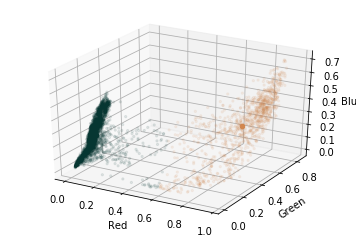

In [12]:
labels=kmeans.labels_
labels=labels.reshape(4240,1)
center=kmeans.cluster_centers_
punti=np.hstack((data_rescaled,labels))

cluster0=punti[punti[:,3]==0]
cluster1=punti[punti[:,3]==1]

fig = pyplot.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

r_0, g_0, b_0 = cluster0[:,0], cluster0[:,1], cluster0[:,2]
r_1, g_1, b_1 = cluster1[:,0], cluster1[:,1], cluster1[:,2]
color_0=center[0,0:3]
color_1=center[1,0:3]


axis.scatter(r_0, g_0, b_0, c=color_0, s=5, marker="o", alpha=0.09)
axis.scatter(r_1, g_1, b_1, c=color_1, s=5, marker="o", alpha=0.09)
axis.scatter(center[0,0],center[0,1],center[0,2],color=color_0,alpha=1)
axis.scatter(center[1,0],center[1,1],center[1,2],color=color_1,alpha=1)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()


## Question 1: 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, i.e., do the two plot matches? 

[ADD YOUR ANSWER HERE]

Come si può vedere i due grafici risultano praticamente sovrapponibili, entrambi i metodi portano agli stessi risultati

## TO DO 6:

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn. Notice that for proper visualization you need to reshape the array back to the original 2D image size

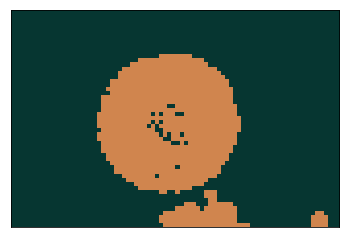

In [13]:
seg_immage=np.zeros((len(labels),3))
for i in range(len(labels)):
    if labels[i]==0:
        seg_immage[i]=center[0]
    if labels[i]==1:
        seg_immage[i]=center[1]

        
    
seg_immage=seg_immage.reshape((53, 80, 3))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(seg_immage)


## Question 2: 

What do you observe? Do you think clustering could be useful for image segmentation ? And for image compression? Comment your answer.

[ADD YOUR ANSWER HERE]


Sicuramente il clustering è utilizzabile per la segmentazione delle immagini, possibilmente separando l'immagine iniziale in più di due clusters in quanto, come si può vedere dall'immagine soprastante, non si riesce a percepire l'immagine di partenza con solo 2 clusters. Rimane comunque un buon modo per ottenere un'immagine compressa.

## TO DO 7:

Now perform again the clustering with the non-rescaled image, using the method provided by sklearn. Plot again: the 3-dimensional points, the 3-dimensional points with color based on membership, the segmented image.

(427, 640, 3)
(273280, 3)


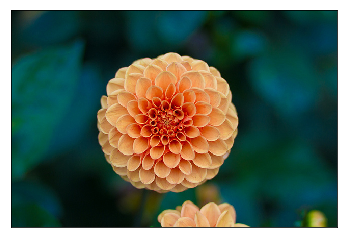

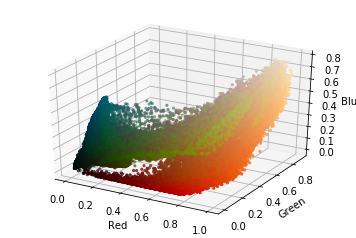

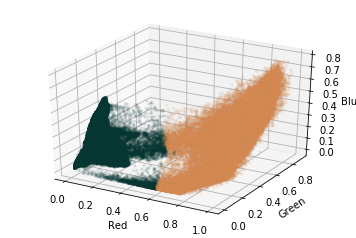

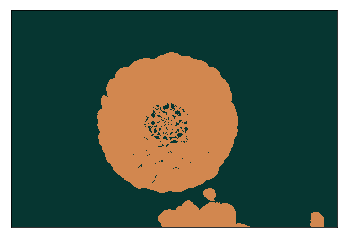

In [14]:
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);
print(flower.shape)

data = flower.reshape(flower.shape[0]*flower.shape[1], 3)
data=data/255.0
print(data.shape)


fig = pyplot.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis

r, g, b = list(data[:,0]), list(data[:,1]), list(data[:,2])


axis.scatter(r, g, b, c=data, s=5, marker="o")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()

#ADD YOUR CODE HERE

kmeans = KMeans(2,max_iter=50).fit(data)

labels=kmeans.labels_
labels=labels.reshape(273280,1)
center=kmeans.cluster_centers_
punti=np.hstack((data,labels))

cluster0=punti[punti[:,3]==0]
cluster1=punti[punti[:,3]==1]

fig = pyplot.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

r_0, g_0, b_0 = cluster0[:,0], cluster0[:,1], cluster0[:,2]
r_1, g_1, b_1 = cluster1[:,0], cluster1[:,1], cluster1[:,2]
color_0=center[0,0:3]
color_1=center[1,0:3]


axis.scatter(r_0, g_0, b_0, c=color_0, s=5, marker="o", alpha=0.09)
axis.scatter(r_1, g_1, b_1, c=color_1, s=5, marker="o", alpha=0.09)
axis.scatter(center[0,0],center[0,1],center[0,2],color=color_0,alpha=1)
axis.scatter(center[1,0],center[1,1],center[1,2],color=color_1,alpha=1)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()


seg_immage=np.zeros((len(labels),3))
for i in range(len(labels)):
    if labels[i]==0:
        seg_immage[i]=center[0]
    if labels[i]==1:
        seg_immage[i]=center[1]

        
    
seg_immage=seg_immage.reshape((427, 640, 3))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(seg_immage)



## Question 3: explain what do you observe

[ADD YOU ANSWER HERE]


Andando ad aumentare la qualità dell' immagine di partenza si può osservare che si è ottenuta una miglior risoluzione anche nell'immagine segmentata. Oltre ai dettagli interni del fiore si può osservare come ora si riesca ad apprezzare anche il contorno.

## TO DO 8:

Now load the landscape image (optional: try also with the skiing image), resize of a factor of 8 and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership. 
Additionally, plot the respective clusters centroids.



/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


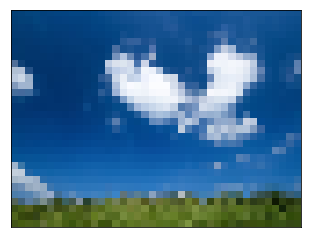

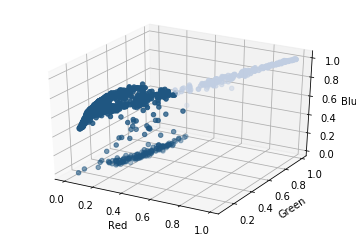

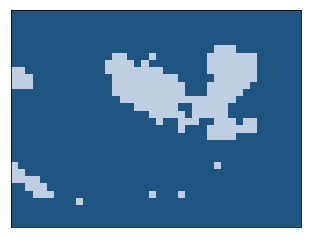

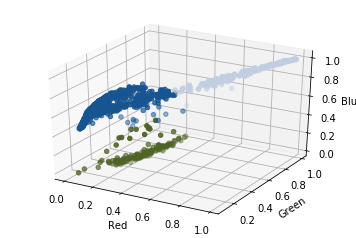

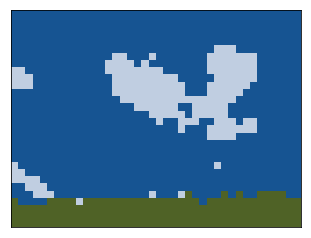

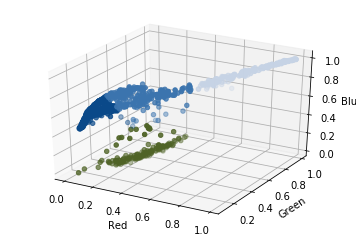

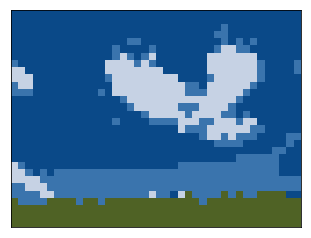

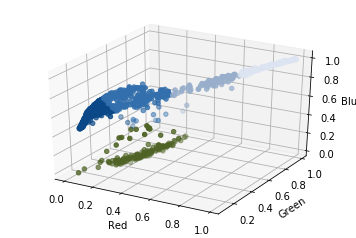

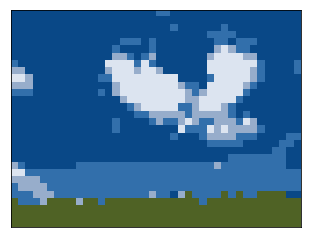

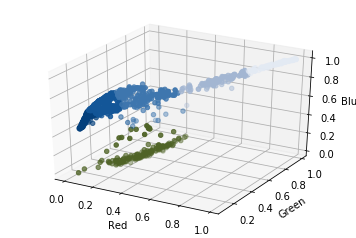

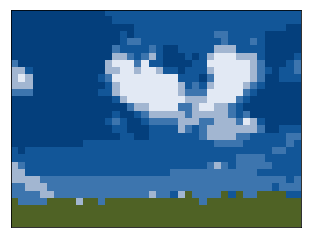

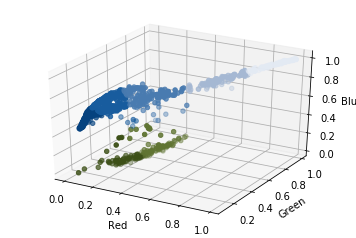

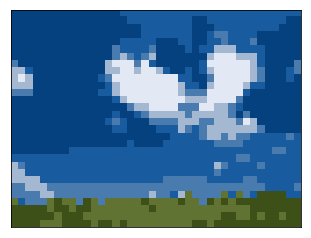

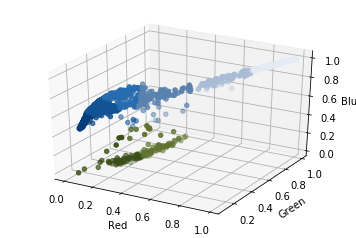

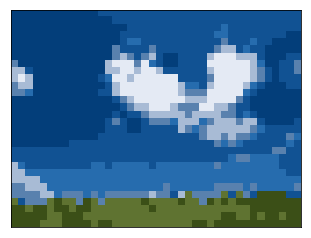

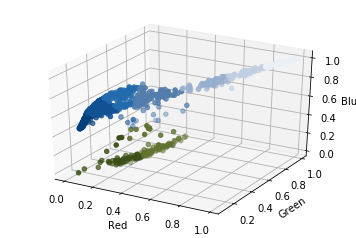

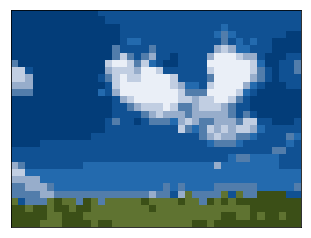

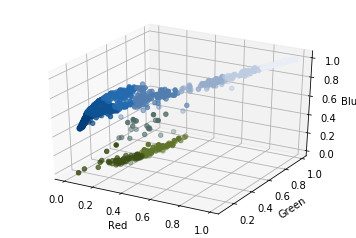

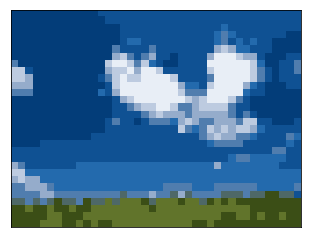

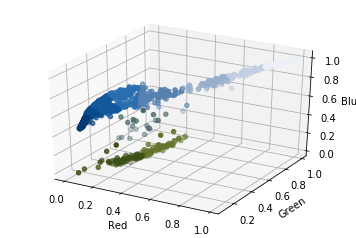

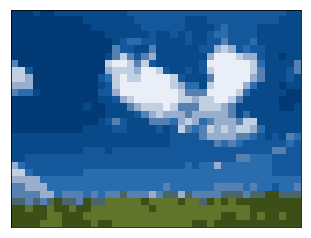

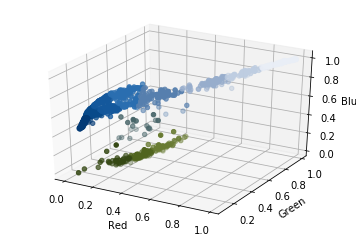

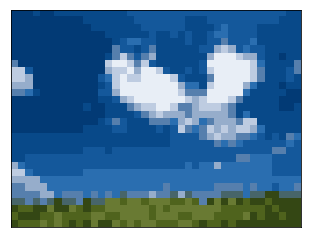

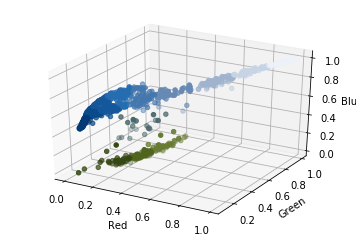

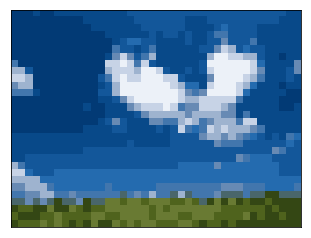

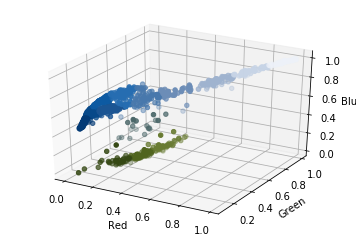

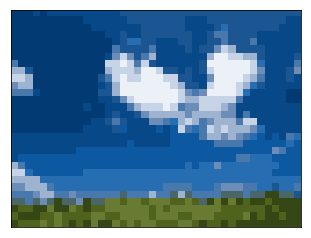

In [15]:
landscape_rescaled = rescale(landscape, 1.0 / 8.0)
data_rescaled = landscape_rescaled.reshape(landscape_rescaled.shape[0]*landscape_rescaled.shape[1], 3)
#print(data_rescaled.shape)
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(landscape_rescaled);

#ADD YOUR CODE HERE
for i in range(2,15):
    
    kmeans = KMeans(i,max_iter=50).fit(data_rescaled)
    labels=kmeans.labels_
    labels=labels.reshape(1200,1)
    center=kmeans.cluster_centers_
    punti=np.hstack((data_rescaled,labels))
        
    fig = pyplot.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    
    for j in range(i):
        axis.scatter(data_rescaled[kmeans.labels_==j][:,0], data_rescaled[kmeans.labels_==j][:,1], data_rescaled[kmeans.labels_==j][:,2], color=center[j])
    
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")
    pyplot.show()
    label = kmeans.labels_.reshape(30, 40)
    data_cluster = np.zeros((30,40,3))
    for j in range(i):
        data_cluster[label == j] = center[j]
    ax = plt.axes(xticks=[], yticks=[])
    ax.imshow(data_cluster);
    pyplot.show()


## TO DO 9:

Plot for different values of k (e.g. k in range(2,15)) the respective error of the kmeans algorithm 

Text(0,0.5,'errori')

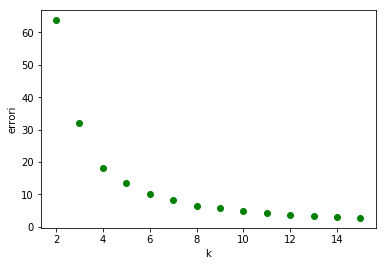

In [16]:
#ADD CODE FOR PLOTTING HERE
errori=[]
for i in range(2,16):
    kmeans = KMeans(i,max_iter=50).fit(data_rescaled)
    errori.append(kmeans.inertia_)

steps=np.linspace(2,15,14)


plt.plot(steps,errori,'o',color='green')
plt.xlabel('k')
plt.ylabel('errori')

A possible way to exploit the error curve in order to set the number of clusters is to apply the "Elbow rule", explained below: 

(explanation from Wikipedia)

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

##  Question 4:

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k ?

Is there a single, clear answer ? 

Which value of k would you choose by applying the "Elbow rule"? Explain why.

[ADD YOUR ANSWERS HERE]

Comparando fra di loro gli errori ottenuti a diversi k si nota che essi tendono sempre a diminuire all' aumentare di k. Si può però notare che mentre i primi 3-4 punti a sinistra del grafico soprastante tendano di volta in volta a dimezzare il loro valore, e quindi si dimezza l'errore  , per gli altri non si ha un calo dell' errore comparabile ad essi. Tale andamento permette di applicare il metodo "Elbow" per selezionare un "k" oltre il quale non si ha una significativa diminuzione dell'errore. Premettendo che la scelta del punto in questione dipende dalla percentuale di varianza scelta, e quindi non è possibile definire il punto di separazione in modo univoco, si procede nel seguente modo:

per i primi 4 punti si ha un dimezzamento dell' errore, dal quinto punto in poi l'errore si mantiene sotto il valore di 10 ed è quindi un buon punto da scegliere come separazione.
#### Tale punto corrisponde a un valore di k=6

## Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

In [17]:
# Import required packages
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics, datasets
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# Load sample data
data = np.load('data/circle_data.npz')
X = data['X']
labels_true = data['labels_true']


## TO DO 10: 

Now exploit the AgglomerativeClustering algorithm on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [18]:
# Compute Agglomerative Clustering

ac = AgglomerativeClustering(n_clusters=2,linkage='single')
    
#ADD YOUR CODE
ac.fit(X)

'''print(ac.labels_)
print(ac.n_leaves_)
print(ac.n_components_)
print(ac.children_)
print(X.shape)
print(ac.labels_.shape)'''

label=ac.labels_.reshape(len(ac.labels_),1)

if X.shape[1]==2:
    X=np.hstack((X,label))



clu1=X[X[:,2]==1]
clu0=X[X[:,2]==0]



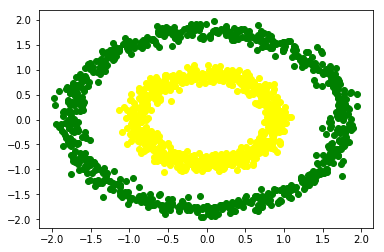

In [19]:

# Plot result

#ADD CODE FOR PLOTTING HERE

plt.scatter(clu0[:,0],clu0[:,1],color='green')
plt.scatter(clu1[:,0],clu1[:,1],color='yellow')


## TO DO 11: 

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

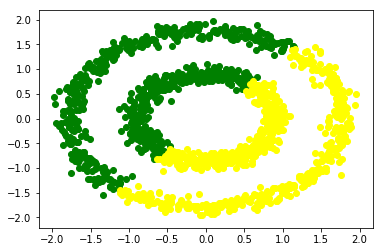

In [20]:
#ADD YOUR CODE HERE

data = np.load('data/circle_data.npz')
X = data['X']
labels_true = data['labels_true']


kmeans = KMeans(2,max_iter=50).fit(X)

center=kmeans.cluster_centers_
labels=kmeans.labels_
labels=labels.reshape(len(labels),1)


if X.shape[1]==2:
    X=np.hstack((X,labels))
    
clu1_=X[X[:,2]==1]
clu0_=X[X[:,2]==0]

plt.scatter(clu0_[:,0],clu0_[:,1],color='green')
plt.scatter(clu1_[:,0],clu1_[:,1],color='yellow')

## Question 5:

Compare the results of K-means and Agglomerative Clustering and explain what you observe



[ADD YOUR ANSWER HERE]

Come si può osservare i due metodi portano a un risultato diverso, mente il metodo K-means porta a una separazione diagonale dei punti, il metodo Agglomerative porta a una separazione in cerchi concentrici.